# Visualising Segmentation

This notebook is a brief overview of loading the network from the bundle with the save weights and performing segmentation on a single 2D image. 

In [1]:
import matplotlib.pyplot as plt
import monai
import torch
import numpy as np

Example image from case SC-N-2 of the [Sunnybrook Cardiac Dataset](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/).

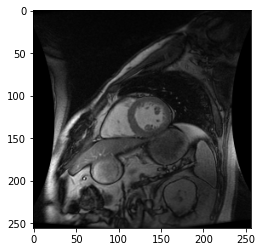

In [2]:
im = np.load("SC-N-2-3-0.npy")
plt.imshow(im, cmap="gray")

The bundle parser is then created to load data from the metadata file and train configuration:

In [3]:
parser = monai.bundle.load_bundle_config("..", "train.json")

A network is created from the configured definition and then initialised with the stored weights:

In [4]:
net = parser.get_parsed_content("network_def")  # "network" loads the network into GPU which we'll avoid for simplicity here
net.load_state_dict(torch.load("../models/model.pt"))

<All keys matched successfully>

The input data is in it's raw state with an arbitrary value range. From the transforms used in training it's clear that the data must be normalised to the \[0,1\] range and be in float32 format. This can be done just by dividing the image by it's largest value because it's known the lowest value is 0. The batch and channels dimensions are added befor being passed to the network:

In [5]:
inputd = torch.from_numpy(im / im.max()).float()
pred = net(inputd[None, None, :, :])  # adding batch and channel dimensions to inputd

The resulting prediction needs to be activated with softmax and then converting into a segmentation by applying argmax in the channel dimension:

In [6]:
pred = torch.softmax(pred[0], dim=0)  # activation and remove batch dimension
seg = torch.argmax(pred, dim=0).data.numpy()  # convert to segmentation

Finally the segmentation can be overlaid with the original image:

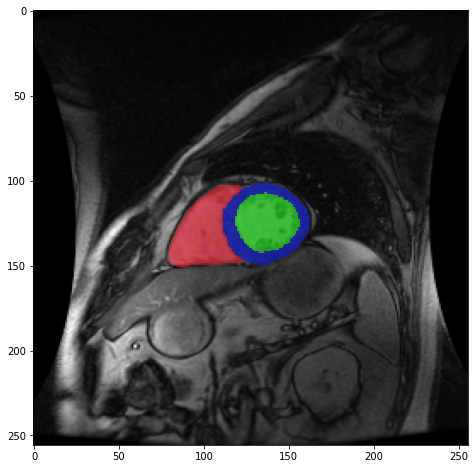

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(im, cmap="gray")
plt.imshow(seg, alpha=(seg != 0) * 0.5, cmap="hsv", interpolation="none")